In [2]:
import os
import numpy as np
import h5py
import json
import torch
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample
from matplotlib.pyplot import imshow
from PIL import Image
import cv2

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def create_input_files(dataset, karpathy_json_path, image_folder, captions_per_image, min_word_freq, output_folder,
                       max_len=100):
    """
    Creates input files for training, validation, and test data.
    :param dataset: name of dataset, one of 'coco', 'flickr8k', 'flickr30k'
    :param karpathy_json_path: path of Karpathy JSON file with splits and captions
    :param image_folder: folder with downloaded images
    :param captions_per_image: number of captions to sample per image
    :param min_word_freq: words occuring less frequently than this threshold are binned as <unk>s
    :param output_folder: folder to save files
    :param max_len: don't sample captions longer than this length
    """

    assert dataset in {'coco', 'flickr8k', 'flickr30k'}
    
    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)
        
    # Read image paths and captions for each image
    train_image_paths = []
    train_image_captions = []
    val_image_paths = []
    val_image_captions = []
    test_image_paths = []
    test_image_captions = []
    word_freq = Counter()
    
    for img in data['images']:
        captions = []
        for c in img['sentences']:
            word_freq.update(c['tokens'])
            if len(c['tokens']) <= max_len:
                captions.append(c['tokens'])
        
        if len(captions) == 0:
            # continue skips the rest of the code in the loop only for this iteration
            continue
        
        path = os.path.join(image_folder, img['filepath'], img['filename']) if dataset == 'coco' else os.path.join(image_folder, img['filename'])
        
        if img['split'] in {'train', 'restval'}:
            train_image_paths.append(path)
            train_image_captions.append(captions)
        elif img['split'] in {'val'}:
            val_image_paths.append(path)
            val_image_captions.append(captions)
        elif img['split'] in {'test'}:
            test_image_paths.append(path)
            test_image_captions.append(captions)
            
    # Sanity check
    assert len(train_image_paths) == len(train_image_captions)
    assert len(val_image_paths) == len(val_image_captions)
    assert len(test_image_paths) == len(test_image_captions)
    
    # Create word map
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
    word_map = {k: v +1 for v, k in enumerate(words)}
    # +1 because the 0 value will be occupied by <pad>
    word_map = {k: v + 1 for v, k in enumerate(words)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0
    
    # Create a base/root name for all files
    base_filename = dataset + '_' + str(captions_per_image) + '_cap_per_img_' +str(min_word_freq) + '_min_word_freq'
    
    # Save word map to a JSON
    with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
        json.dump(word_map, j)
    
    # Sample captions for each image, save images to HDF5 file, and captions and their lengths to JSON files
    seed(123)
    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'), 
                                   (val_image_paths, val_image_captions, 'VAL'),
                                  (test_image_paths, test_image_captions, 'TEST')]:
        
        with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
            # Make a note of the number of captions we are sampling per image
            h.attrs['captions_per_image'] = captions_per_image
            
            # Create dataset inside HDF5 file to store images
            images = h.create_dataset('images', (len(impaths), 3 ,256, 256), dtype='uint8')
            
            print("\nReading %s images and captions, storing to file...\n" % split)
            
            enc_captions = []
            caplens = []
            
            #tqdm shows progress bars
            # for every image
            for i, path in enumerate(tqdm(impaths)):
                
                # Sample captions
                if len(imcaps[i]) < captions_per_image:
                    captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
                
                else:
                    captions = sample(imcaps[i], k=captions_per_image)
                    
                #Sanity check
                assert len(captions) == captions_per_image
                
                # Read images
                img = np.array(Image.open(impaths[i]))
                if len(img.shape) ==2:
                    img= img[:,:,np.newaxis]
                    img = np.concatenate([img, img, img], axis=2)
                img = imresize(img, (256, 256))
                assert img.shape == (3, 256, 256)
                assert np.max(img) <= 255
                
                # Save image to HDF5 file
                
                images[i] = img
                # for every caption in the image (each phrase - list of words)
                for j, c in enumerate(captions):
                    # Encode captions
                    # the get method of the dictionary word_map has a second argument, the default value
                    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))
                    
                    # Find caption legths
                    c_len = len(c) + 2
                    enc_captions.append(enc_c)
                    caplens.append(c_len)
                    
            # Sanity check
            assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)
            
            #Save encoded captions and their lenghts to JSON files
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
                json.dump(enc_captions, j)

            with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
                json.dump(caplens, j)
                
def init_embedding(embeddings):
    """
    Fills embedding tensor with values from the uniform distribution.
    :param embeddings: embedding tensor
    """
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)


def load_embeddings(emb_file, word_map):
    """
    Creates an embedding tensor for the specified word map, for loading into the model.
    :param emb_file: file containing embeddings (stored in GloVe format)
    :param word_map: word map
    :return: embeddings in the same order as the words in the word map, dimension of embeddings
    """

    # Find embedding dimension
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())

    # Create tensor to hold embeddings, initialize
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)

    # Read embedding file
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        # Ignore word if not in train_vocab
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)
    
    
def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)


In [30]:
files = ['data/train2014/'+f for f in os.listdir('data/train2014')]
jsons = ['data/caption_datasets/' + f for f in os.listdir('data/caption_datasets')]

In [34]:
with open(jsons[0]) as f:
    data = json.load(f)

In [45]:
data['images'][0]

{'filepath': 'val2014',
 'sentids': [770337, 771687, 772707, 776154, 781998],
 'filename': 'COCO_val2014_000000391895.jpg',
 'imgid': 0,
 'split': 'test',
 'sentences': [{'tokens': ['a',
    'man',
    'with',
    'a',
    'red',
    'helmet',
    'on',
    'a',
    'small',
    'moped',
    'on',
    'a',
    'dirt',
    'road'],
   'raw': 'A man with a red helmet on a small moped on a dirt road. ',
   'imgid': 0,
   'sentid': 770337},
  {'tokens': ['man',
    'riding',
    'a',
    'motor',
    'bike',
    'on',
    'a',
    'dirt',
    'road',
    'on',
    'the',
    'countryside'],
   'raw': 'Man riding a motor bike on a dirt road on the countryside.',
   'imgid': 0,
   'sentid': 771687},
  {'tokens': ['a',
    'man',
    'riding',
    'on',
    'the',
    'back',
    'of',
    'a',
    'motorcycle'],
   'raw': 'A man riding on the back of a motorcycle.',
   'imgid': 0,
   'sentid': 772707},
  {'tokens': ['a',
    'dirt',
    'path',
    'with',
    'a',
    'young',
    'person',

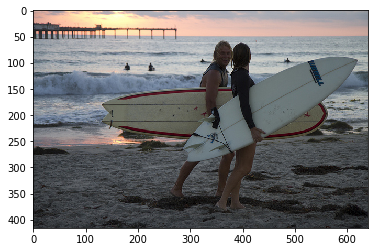

In [29]:
imshow(Image.open(files[0]))